# Import libraries

In [17]:
!pip install sklearn
!pip install pandas
!pip install matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# empty list to append metric values
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []

In [18]:
data = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# for later use
features_num = 14

# set predictive window according with tuning best results
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values in the whole data set
data.fillna(data.mean(), inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

from sklearn.preprocessing import MinMaxScaler

# data scaling  (including offer (y))
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Required functions to put data into required shape for LSTM:

In [19]:
# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# Parameters:

In [20]:
steps = 96
n_hidden = 1
units = 150
batch_size = 96
epochs = 1000

# Set up X and y for train, test and val into correct shapes

In [21]:
# divide features and labels
X_train = data_train[:, 0:14] 
y_train = data_train[:, -1]
X_test = data_test[:, 0:14] 
y_test = data_test[:, -1] 

# divide data into validation and normal test 
X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size = 0.15, shuffle=False)

# put data into correct shape
X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

# cut data
X_train = cut_data(X_train, batch_size)
y_train = cut_data(y_train, batch_size)
X_test = cut_data(X_test, batch_size)
y_test = cut_data(y_test, batch_size)
X_val = cut_data(X_val, batch_size)
y_val = cut_data(y_val, batch_size)

# Import libraries:

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

# Design LSTM:

In [23]:
def regressor_tunning(kernel_initializer = 'he_normal',
                      bias_initializer = initializers.Ones()):
    model = Sequential()
    if n_hidden == 0:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    else:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        model.add(LSTM(units = units, 
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop()
    model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
    return model

model = regressor_tunning()

# Train the model for different epochs

Train on 6240 samples, validate on 960 samples
Epoch 1/100
6240/6240 [==============================] - 59s 9ms/step - loss: 0.3270 - mse: 0.3270 - mae: 0.3671 - val_loss: 0.0391 - val_mse: 0.0391 - val_mae: 0.1956
Epoch 2/100
6240/6240 [==============================] - 57s 9ms/step - loss: 0.0630 - mse: 0.0630 - mae: 0.1987 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0270
Epoch 3/100
6240/6240 [==============================] - 57s 9ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1147 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0405
Epoch 4/100
6240/6240 [==============================] - 56s 9ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0693 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0223
Epoch 5/100
6240/6240 [==============================] - 55s 9ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0448 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0164
Epoch 6/100
6240/6240 [==============================] - 55s 9ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0314 

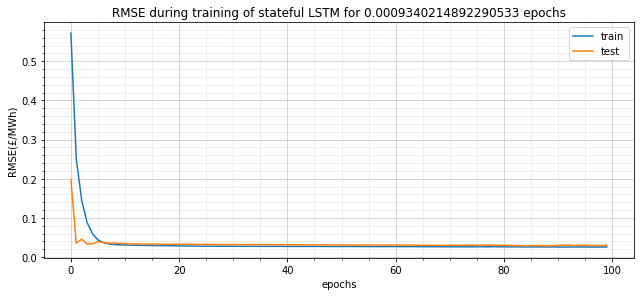

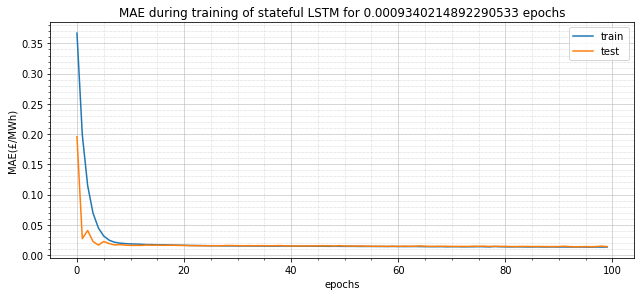

ValueError: operands could not be broadcast together with shapes (150,) (1152,) 

In [24]:
%matplotlib notebook

epochs = [100, 500, 1000]

for i in epochs:
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = i,
                        shuffle = False, 
                        validation_data = (X_val, y_val))
    
    # required before predicitons
    model.reset_states()
    
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    rmse = []
    val_rmse = []

    for i in history.history['mse']:
        rmse.append(i ** 0.5)

    for i in history.history['val_mse']:
        val_rmse.append(i ** 0.5)

    plt.figure(figsize=(9,4))
    plt.plot(rmse, label = 'train')
    plt.plot(val_rmse, label = 'test')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('RMSE(£/MWh)')
    plt.tight_layout()
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5')
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.title('RMSE during training of stateful LSTM for {} epochs'.format(i))
    plt.savefig('Plot_LSTM_stateful_RMSE_during_training_{}_epochs.png'.format(i))
    plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(history.history['mae'], label = 'train')
    plt.plot(history.history['val_mae'], label = 'test')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('MAE(£/MWh)')
    plt.tight_layout()
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5')
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.title('MAE during training of stateful LSTM for {} epochs'.format(i))
    plt.savefig('Plot_LSTM_stateful_MAE_during_training_{}_epochs.png'.format(i))
    plt.show()
    
    # cannot use inverse function; prices col = 14
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])

    # =============================================================================
    # METRICS EVALUATION (1) for the whole test set
    # =============================================================================
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    # calculate metrics
    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)

    # append to list
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # METRICS EVALUATION (2) on spike regions
    # =============================================================================

    # download spike indication binary set
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])

    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values

    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]

    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)

    # append ot lists
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # METRIC EVALUATION (3) on normal regions
    # =============================================================================

    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)

    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)

    # append to list
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)
    
    # calculate residuals
    # Residual = list(y_test[-150:]) - y_pred[:,0][-1550:]

    # plot values
    plt.figure(figsize=(11,5))
    plt.plot(y_pred[-150:], label = 'Predicted values', linewidth = 0.8)
    plt.plot(list(y_test)[-150:], label = 'Real values', linewidth = 0.8)
    # plt.plot(Residual, label = 'Residual error', linewidth = 0.5)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5')
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.xlabel('Accumulated SP')
    plt.ylabel('(£/MWh)', fontsize = 12)
    plt.title('Stateful LSTM with {} epochs: Real and predicted \nmaximum accepted offer values for the end of 2010'.format(i)
              , fontsize=12)
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.savefig('Plot_LSTM_stateful_prediction_{}_epochs.png'.format(i))
    

# Redo some the plot:

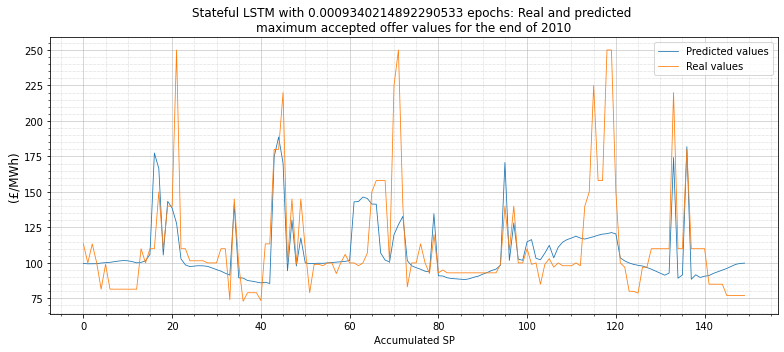

In [26]:
    plt.figure(figsize=(11,5))
    plt.plot(y_pred[-150:], label = 'Predicted values', linewidth = 0.8)
    plt.plot(list(y_test)[-150:], label = 'Real values', linewidth = 0.8)
    # plt.plot(Residual, label = 'Residual error', linewidth = 0.5)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5')
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.xlabel('Accumulated SP')
    plt.ylabel('(£/MWh)', fontsize = 12)
    plt.title('Stateful LSTM with {} epochs: Real and predicted \nmaximum accepted offer values for the end of 2010'.format(i)
              , fontsize=12)
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.savefig('Plot_LSTM_stateful_prediction_{}_epochs.png'.format(i))

In [27]:
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

In [28]:
results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,28.132787,16.069928,23.482994,14.987701,28.754697,16.229459
